In [29]:
import pandas as pd 
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

# OpenScout Project

### Goal: Lengthen User Longevity on the OpenScout Platform

#### 1. User Cohort Survival Timeline
#### 2. Customer Segmentation Timeline (Churned, Unchurned, Top 100)
#### 3. User Engagement with Platform

## Load Data

In [33]:
onepager_raises = pd.read_csv("data/Week 9/pt2/onepager_raises.csv")
onepager_faqs = pd.read_csv('data/Week 9/pt1/onepager_faqs.csv')
user_onepagers = pd.read_csv("data/Week 9/pt2/user_onepagers.csv") #for merging
visitors = pd.read_csv("data/Week 9/pt2/visitors.csv") #for merging
users = pd.read_csv("data/Week 9/pt2/users.csv") #for merging
op_visitor_stats = pd.read_csv("data/Week 9/pt2/onepager_visitor_stats.csv") #visit rate and "first view/10 view" timeline
op_visitors = pd.read_csv("data/Week 9/pt2/onepager_visitors.csv") #share internally/externally 
onepagers = pd.read_csv("data/Week 9/pt2/onepagers.csv") #characteristics of onepager 
traction = pd.read_csv("data/Week 9/pt2/onepager_traction_and_performance.csv") #how well onepager is doing 
founders = pd.read_csv("data/Week 9/pt1/founders.csv") #founder profiles
notifs = pd.read_csv("data/Week 9/pt1/notifications.csv") #can be used to see most recent views maybe?
op_analytics = pd.read_csv("data/Week 9/pt1/onepager_analytics.csv") #dataset with views and bounce rate 
op_founders = pd.read_csv("data/Week 9/pt1/onepager_founders.csv") #join table
top_onepagers = pd.read_csv("data/top_onepagers.csv") #top five onepagers 
master = pd.read_csv("data/aggregated/all_founders_cleaned_2.csv") #all founders
master2 = pd.read_csv("data/aggregated/w9_agg.csv")

## 1. User Cohort Survival Timeline

this is my team member's work but useful for explanation

### Clean Data

In [22]:
# left merge founders & onepager_founders on founder uuid
tbl1 = pd.merge(founders, op_founders[['onepager_uuid', 'founder_uuid']], left_on = 'uuid', right_on='founder_uuid', how='left').drop(columns=['founder_uuid'])
tbl1 = tbl1.rename(columns=
                   {'uuid': 'founder_uuid', 
                    'created_at': 'founder_profile_created', 
                    'updated_at': 'founder_profile_updated',
                   'image_key': 'founder_image',
                   'name': 'founder_name',
                   'title': 'founder_title',
                   'links': 'founder_link',
                   'bio': 'founder_bio'})

In [23]:
# left merge tbl1 with onepagers (same result as inner merge)
tbl2 = pd.merge(tbl1, onepagers[~onepagers['uuid'].isna()], how='left', left_on='onepager_uuid', right_on='uuid')
tbl2 = tbl2.drop(columns=['uuid'])
tbl2 = tbl2.rename(columns={
    'image_key': 'onepager_image_key',
    'description':'company_description',
    'short_description': 'company_short_description',
    'slug': 'company_slug',
    'links': 'onepager_links',
    'created_at': 'onepager_created',
    'updated_at': 'onepager_updated',
    'color': 'onepager_color',
    'status': 'onepager_stats'
})

In [24]:
# left merge w faq data, but clean faq data first
onepager_faqs['created_at'] = pd.to_datetime(onepager_faqs['created_at'])
onepager_faqs['updated_at'] = pd.to_datetime(onepager_faqs['updated_at'])

onepager_faqs_most_rec_activity = onepager_faqs[['onepager_uuid', 'created_at', 'updated_at']].groupby('onepager_uuid').agg(max)

tbl3 = pd.merge(tbl2, onepager_faqs_most_rec_activity, on ='onepager_uuid', how='left')
tbl3 = tbl3.rename(columns={
    'title': 'question',
    'description': 'answer',
    'created_at': 'faq_created',
    'updated_at': 'faq_updated'
})

In [25]:
#left merge with onepager_raises
tbl4 = pd.merge(tbl3, onepager_raises, on = 'onepager_uuid', how='left')
tbl4 = tbl4.drop(columns=['uuid'])
tbl4 = tbl4.rename(columns = {
    'created_at': 'fundraiser_created',
    'updated_at': 'fundraiser_updated'
})

In [26]:
# left merge with onepager_visitor_stats, but clean the data first so that each row has 1 onepager & has the most recent time that it got visited
op_visitor_stats['created_at'] = pd.to_datetime(op_visitor_stats['created_at'])
op_visitor_stats['updated_at'] = pd.to_datetime(op_visitor_stats['updated_at'])

onepager_most_recent_visit = op_visitor_stats[['onepager_uuid', 'created_at', 'updated_at']].groupby('onepager_uuid').agg(max)

tbl5 = pd.merge(tbl4, onepager_most_recent_visit, on ='onepager_uuid', how='left')
tbl5 = tbl5.rename(columns={
    'created_at': 'visits_created',
    'updated_at': 'visits_updated'
})

time_cols = ['founder_profile_created', 'founder_profile_updated', 
             'onepager_created', 'onepager_updated', 
             'faq_created', 'faq_updated', 
            'fundraiser_created', 'fundraiser_updated',
            'visits_created', 'visits_updated']

for col in time_cols:
    tbl5[col] = pd.to_datetime(tbl5[col]).dt.date
    
tbl5['last_activity'] = tbl5[time_cols].apply(max, axis=1)

/opt/conda/lib/python3.9/site-packages/pandas/core/apply.py:828: FutureWarning: Comparison of NaT with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.
  results[i] = self.f(v)


In [27]:
# label churn v active user
churn_threshold = pd.to_datetime('today').date() - pd.DateOffset(30)
churn = tbl5.last_activity < churn_threshold

tbl5['tenure'] = pd.to_datetime('today').date() - tbl5['founder_profile_created']
tbl5['churn'] = churn

/opt/conda/lib/python3.9/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


### Kaplan Meier Survival Curve

#### All Customers

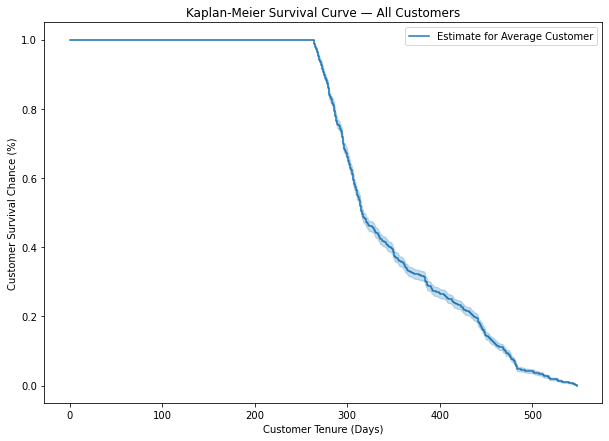

In [30]:
# fitting kmf to churn data
import lifelines

t = tbl5['tenure'].dt.days.values
churn = tbl5['churn'].values
kmf = lifelines.KaplanMeierFitter()
kmf.fit(t, event_observed=churn, label='Estimate for Average Customer')
# plotting kmf curve
fig, ax = plt.subplots(figsize=(10,7))
kmf.plot(ax=ax)
ax.set_title('Kaplan-Meier Survival Curve — All Customers')
ax.set_xlabel('Customer Tenure (Days)')
ax.set_ylabel('Customer Survival Chance (%)')
plt.show()

#### Founder with vs without onepager

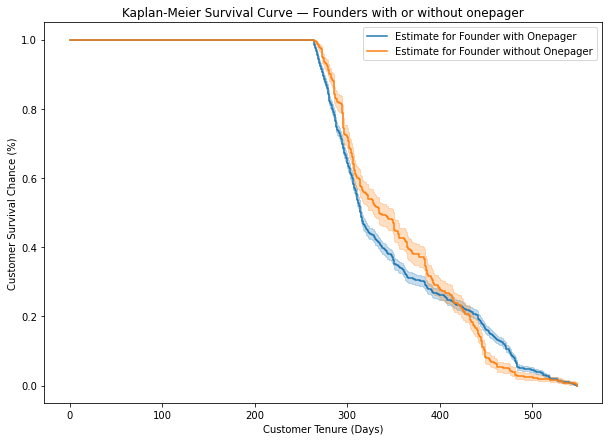

In [31]:
founder_w_onepager = tbl5[~tbl5['onepager_uuid'].isna()]
t_w_onepager = founder_w_onepager['tenure'].dt.days.values
churn_w_onepager = founder_w_onepager['churn'].values
kmf_w_onepager = lifelines.KaplanMeierFitter()
kmf_w_onepager.fit(t_w_onepager, event_observed=churn_w_onepager, label='Estimate for Founder with Onepager')

founder_wo_onepager = tbl5[tbl5['onepager_uuid'].isna()]
t_wo_onepager = founder_wo_onepager['tenure'].dt.days.values
churn_wo_onepager = founder_wo_onepager['churn'].values
kmf_wo_onepager = lifelines.KaplanMeierFitter()
kmf_wo_onepager.fit(t_wo_onepager, event_observed=churn_wo_onepager, label='Estimate for Founder without Onepager')


# plotting kmf curve
fig, ax = plt.subplots(figsize=(10,7))
kmf_w_onepager.plot(ax=ax)
kmf_wo_onepager.plot(ax=ax)

ax.set_title('Kaplan-Meier Survival Curve — Founders with or without onepager')
ax.set_xlabel('Customer Tenure (Days)')
ax.set_ylabel('Customer Survival Chance (%)')
plt.show()

#### Founder with vs without complete profile

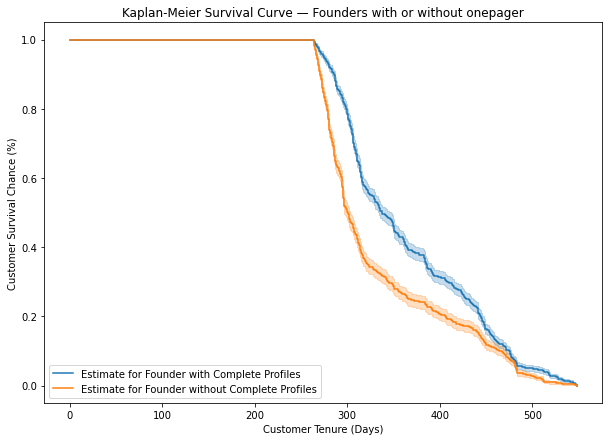

In [32]:
tbl5['founder_complete_profile'] = [False if (pd.isna(row['founder_image']) or pd.isna(row['founder_name']) 
                                    or pd.isna(row['founder_title']) or pd.isna(row['founder_link']) or 
                                    pd.isna(row['founder_bio'])) 
                                    else True
                                    for index, row in tbl5.iterrows()]

founder_complete_profile = tbl5[tbl5['founder_complete_profile']]
t_complete_profile = founder_complete_profile['tenure'].dt.days.values
churn_complete_profile = founder_complete_profile['churn'].values
kmf_complete_profile = lifelines.KaplanMeierFitter()
kmf_complete_profile.fit(t_complete_profile, event_observed=churn_complete_profile, label='Estimate for Founder with Complete Profiles')

founder_no_complete_profile = tbl5[~tbl5['founder_complete_profile']]
t_no_complete_profile = founder_no_complete_profile['tenure'].dt.days.values
churn_no_complete_profile = founder_no_complete_profile['churn'].values
kmf_no_complete_profile = lifelines.KaplanMeierFitter()
kmf_no_complete_profile.fit(t_no_complete_profile, event_observed=churn_no_complete_profile, label='Estimate for Founder without Complete Profiles')


# plotting kmf curve
fig, ax = plt.subplots(figsize=(10,7))
kmf_complete_profile.plot(ax=ax)
kmf_no_complete_profile.plot(ax=ax)

ax.set_title('Kaplan-Meier Survival Curve — Founders with or without onepager')
ax.set_xlabel('Customer Tenure (Days)')
ax.set_ylabel('Customer Survival Chance (%)')
plt.show()

## 2. Customer Segmentation Timeline (Churned, Unchurned, Top 100)

**Purpose:** A customer behavior timeline for each user group to better distinguish them. Use timeline to provide recommendations for OpenScout on how to minimize churned users and move them closer towards top 100.

**Major Milestones:** profile creation, first view, tenth view, fundraiser created, faq created, first internal share, first external share, tenth share, twentieth share, last activity, churn/today

### Clean and Refine Data 

master2: contains `profile creation`, `faq created`, `fundraiser created`, `last activity` 

onepager_visits: contains `first view` and `tenth view`

Sunny's past work has the rest ... `external share`, `internal share`, `tenth share`, `twentieth share`

In [31]:
#filter out testing accounts 
test_op_uuids = ['9c8d5744-d2fd-42c7-aabd-d5dc917868c4', 'f4e1ce5b-4c29-49a7-a786-a8f2dd37dd58', '267af659-c847-4c89-8bc1-bb4a8aa966a7', '7de2a967-3c6c-43a0-be43-a8003582ff65', '493259ed-956f-4148-bf6b-659bfda9911f', '13af6dd7-593c-4426-9db4-11e0b2beca84', '4ca8698c-e62a-443c-9151-4410540272fc', '2b07c43b-5431-4fcd-80d6-afe6755ad685']
onepager_visitors = op_visitors[op_visitors["onepager_uuid"].isin(test_op_uuids) == False]

In [32]:
# master2 
master2.head()

,Unnamed: 0,founder_uuid,founder_image,founder_name,founder_title,founder_link,founder_bio,founder_profile_created,founder_profile_updated,onepager_uuid,...,note,is_current,fundraiser_created,fundraiser_updated,visits_created,visits_updated,last_activity,tenure,churn,founder_complete_profile
0,0,0011279a-0c95-4f3d-8ae0-a0916fe54afd,8ea8552e-0588-4c8c-b2ff-30ba76349136,Will Valori,Founder,"{""linkedin"": ""https://www.linkedin.com/in/will...","Strategy at BCG, early childhood education at ...",2020-08-17,2020-10-27,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-27,252 days,True,True
1,1,0014bb20-d843-42f5-8af4-d30de649e1f9,186f81e4-762b-4e6a-b0a5-5bb454e74410,Saad Usmani,Founder & CEO,"{""linkedin"": ""https://www.linkedin.com/in/saad...","Currently, 23, I've founded AirwaysX with an a...",2020-09-17,2020-10-21,9f452da8-2745-45d2-85ec-2d5a48aed684,...,"For website and app development, marketing str...",1.0,2020-09-17,2020-10-21,2021-02-17,2021-02-17,2021-02-17,221 days,True,True
2,2,0026b115-ef03-4a6d-a474-cc6e98672232,5959f354-fc18-43e9-a4ee-ce64e445c7fd,Constant Tedder,Co-Founder,"{""twitter"": """", ""website"": """", ""facebook"": """",...","CEO@the Hive, previously CEO@Jagex, founder @D...",2021-03-12,2021-03-23,c6308c3c-89ce-4b03-8272-1eb3fc091f12,...,FlyFarm is raising USD 3m in a SAFE round.,1.0,2021-03-12,2021-03-23,2021-03-23,2021-03-23,2021-03-23,45 days,True,True
3,3,004a3eee-e647-4495-bc42-a7e588acb32d,a39ea233-6d97-4d79-b044-86e5e009d453,Mat Sherman,Founder,"{""twitter"": ""http://twitter.com/mat_Sherman/""}",Mat is the founder of SeedScout. Before starti...,2020-12-23,2021-03-26,29d43a79-4d5f-4fa6-a07d-b60225839117,...,NaN,1.0,2020-12-23,2021-03-26,2021-04-15,2021-04-15,2021-04-15,124 days,False,True
4,4,004d7015-53dd-4f0d-81f6-a33e53ee537c,6a35784c-565d-466b-b46a-8d8fbd231e7f,Laura Robbins,COO & Co-Founder,"{""linkedin"": ""https://www.linkedin.com/in/laur...",Ms. Robbins is the COO of Advocatia. Ms. Robbi...,2020-12-17,2021-01-10,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2021-01-10,130 days,True,True


In [33]:
#Sunny's work 
onepager_visitors['created_at'] = pd.to_datetime(onepager_visitors['created_at'])
onepager_visitors['updated_at'] = pd.to_datetime(onepager_visitors['updated_at'])
onepager_visitors['stats'] = [x[11:15] for x in onepager_visitors['stats']]
onepager_visitors = onepager_visitors.rename(columns={'stats':'shared_externally'})
onepager_visitors['shared_externally'] = [True if x =='true' else False for x in onepager_visitors['shared_externally']]
onepager_visits = onepager_visitors[['onepager_uuid', 'shared_externally', 'created_at']].sort_values("created_at")

external_share = onepager_visits[onepager_visits['shared_externally']].groupby('onepager_uuid').agg(list)
external_share['first_external_share'] = [min(x) for x in external_share['created_at']]
external_share.drop(columns=['shared_externally', 'created_at'], inplace=True)
external_share = pd.merge(op_founders, external_share, left_on = "onepager_uuid", right_index = True)[["founder_uuid", "first_external_share"]].set_index("founder_uuid")

internal_share = onepager_visits[~onepager_visits['shared_externally']].groupby('onepager_uuid').agg(list)
internal_share['first_internal_share'] = [min(x) for x in internal_share['created_at']]
internal_share.drop(columns=['shared_externally', 'created_at'], inplace=True)
internal_share = pd.merge(op_founders, internal_share, left_on = "onepager_uuid", right_index = True)[["founder_uuid", "first_internal_share"]].set_index("founder_uuid")

tenth_share = onepager_visits.groupby("onepager_uuid").nth(10).rename(columns = {"created_at":"tenth_share"})
tenth_share = pd.merge(op_founders, tenth_share, left_on = "onepager_uuid", right_index = True)[["founder_uuid", "tenth_share"]].set_index("founder_uuid")
twentieth_share = onepager_visits.groupby("onepager_uuid").nth(20).rename(columns = {"created_at":"twentieth_share"})
twentieth_share = pd.merge(op_founders, twentieth_share, left_on = "onepager_uuid", right_index = True)[["founder_uuid", "twentieth_share"]].set_index("founder_uuid")

/tmp/ipykernel_25/390589215.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  onepager_visitors['created_at'] = pd.to_datetime(onepager_visitors['created_at'])
/tmp/ipykernel_25/390589215.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  onepager_visitors['updated_at'] = pd.to_datetime(onepager_visitors['updated_at'])
/tmp/ipykernel_25/390589215.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

In [34]:
# onepager_visits 
onepager_visits = pd.merge(onepager_visits, op_founders[["onepager_uuid", "founder_uuid"]], left_on = "onepager_uuid", right_on = "onepager_uuid").sort_values("created_at")
onepager_visits.head()

,onepager_uuid,shared_externally,created_at,founder_uuid
0,b279319e-ec4f-4284-8b1b-f8ab6c115b1f,True,2020-07-09 02:11:23,2c6855c3-9d5c-4c9e-a3ef-4386c76ac95a
1,b279319e-ec4f-4284-8b1b-f8ab6c115b1f,True,2020-07-09 02:11:23,6a4d8b69-4d23-4340-90d5-cecb022ebc01
6,7a05a253-fd22-4bab-982e-13cc1898e3f1,True,2020-07-09 14:11:29,9749d82a-4bc3-4a6d-9a16-b6a31b315512
7,7a05a253-fd22-4bab-982e-13cc1898e3f1,True,2020-07-09 14:11:29,a62657af-5fea-4a37-ae01-c08478744172
8,7a05a253-fd22-4bab-982e-13cc1898e3f1,True,2020-07-09 14:11:29,ac68090f-e00c-496e-9a0f-441ddf2d6531


### Pipeline 

In [35]:
def pipeline(timeline, group):
    """ Returns dataframe displaying days from onepager creation to major milestones. 
    
    Args: 
    - timeline: dataframe of each milestone in terms of datetime objects
    - group: string indicating churn v unchurn
    
    """
    op_to_profile = timeline.founder_profile_created - timeline.onepager_created
    op_to_first_view = timeline.first_view - timeline.onepager_created
    op_to_tenth_view = timeline.tenth_view - timeline.onepager_created
    op_to_fund_create = timeline.fundraiser_created - timeline.onepager_created
    op_to_faq_create = timeline.faq_created - timeline.onepager_created
    op_to_internal = timeline.first_internal_share - timeline.onepager_created
    op_to_external = timeline.first_external_share - timeline.onepager_created
    op_to_tenth_share = timeline.tenth_share - timeline.onepager_created
    op_to_twentieth_share = timeline.twentieth_share - timeline.onepager_created
    op_to_last_activity = timeline.last_activity - timeline.onepager_created
        
    data = list(zip(op_to_profile,
        op_to_first_view,
        op_to_tenth_view,
        op_to_fund_create,
        op_to_faq_create,                        
        op_to_internal,
        op_to_external,
        op_to_tenth_share, 
        op_to_twentieth_share,
        op_to_last_activity))

    cols = ['op_to_profile',
    'op_to_first_visit',
    'op_to_tenth_visit',
    'op_to_fund_create',     
    'op_to_faq_create',
    'op_to_internal',
    'op_to_external',
    'op_to_tenth_share', 
    'op_to_twentieth_share',
    'op_to_last_activity',]
    
    timeline_days = pd.DataFrame(data = data, columns = cols)
    
    if group == "churn":
        op_to_churn = timeline.churned - timeline.onepager_created
        timeline_days["churn"] = op_to_churn
        
    if group == "unchurn" or group == "top100":
        op_to_today = timeline.today - timeline.onepager_created
        timeline_days["today"] = op_to_today
    
    return timeline_days

In [36]:
def iqr_timeline(data, quartile): 
    """ Returns a list of Timedelta objects of each major milestone (first view, internal share, etc...) at specific quartile.
    
    Args:
    - data: pipelined dataframe 
    - quartile: quartile we want to assess (0.25, 0.5, 0.75)
   
   """
    
    timeline = []
    for i in np.arange(data.shape[1]): 
        timeline.append(data.iloc[:, i].quantile(quartile))
    return timeline

### Churned

In [37]:
#aggregate on churned_timeline
churned_master = master2[master2["churn"] == True]

#founder profile + onepager creation date 
churned_timeline = churned_master.set_index("founder_uuid")[["founder_profile_created"]]
op_created_time = pd.merge(onepagers, op_founders[["onepager_uuid", "founder_uuid"]], left_on = "uuid", right_on = "onepager_uuid")[["founder_uuid", "created_at"]].set_index("founder_uuid")
churned_timeline = pd.merge(churned_timeline, op_created_time, left_index = True, right_index = True).rename(columns = {"created_at": "onepager_created"})
churned_timeline["founder_profile_created"] = pd.to_datetime(churned_timeline["founder_profile_created"]).dt.date
churned_timeline["onepager_created"] = pd.to_datetime(churned_timeline["onepager_created"]).dt.date

#first view
first_view = onepager_visits.groupby("founder_uuid").first()
churned_timeline = pd.merge(churned_timeline, first_view[["created_at"]], how = "left", left_index = True, right_index = True).rename(columns = {"created_at":"first_view"})
churned_timeline["first_view"] = pd.to_datetime(churned_timeline["first_view"]).dt.date

#tenth view
tenth_view = onepager_visits.groupby("founder_uuid").nth(10)
churned_timeline = pd.merge(churned_timeline, tenth_view[["created_at"]], how = "left", left_index = True, right_index = True).rename(columns = {"created_at":"tenth_view"})
churned_timeline["tenth_view"] = pd.to_datetime(churned_timeline["tenth_view"]).dt.date

#fundraiser created
master2["fundraiser_created"] = pd.to_datetime(master2["fundraiser_created"]).dt.date
raises_created = pd.merge(churned_timeline, master2[["founder_uuid", "fundraiser_created"]], left_index = True, right_on = "founder_uuid").set_index("founder_uuid")
churned_timeline = pd.merge(churned_timeline, raises_created[["fundraiser_created"]], how = "left", left_index = True, right_index = True)

#faq created 
master2["faq_created"] = pd.to_datetime(master2["faq_created"]).dt.date
faq_created = pd.merge(churned_timeline, master2[["founder_uuid", "faq_created"]], left_index = True, right_on = "founder_uuid").set_index("founder_uuid")
churned_timeline = pd.merge(churned_timeline, faq_created[["faq_created"]], how = "left", left_index = True, right_index = True)

#first internal share 
churned_timeline = pd.merge(churned_timeline, internal_share, how = "left", left_index = True, right_index = True)
churned_timeline["first_internal_share"] = pd.to_datetime(churned_timeline["first_internal_share"]).dt.date

#first external share 
churned_timeline = pd.merge(churned_timeline, external_share, how = "left", left_index = True, right_index = True)
churned_timeline["first_external_share"] = pd.to_datetime(churned_timeline["first_external_share"]).dt.date

#tenth share 
churned_timeline = pd.merge(churned_timeline, tenth_share, how = "left", left_index = True, right_index = True)
churned_timeline["tenth_share"] = pd.to_datetime(churned_timeline["tenth_share"]).dt.date

#twenty share 
churned_timeline = pd.merge(churned_timeline, twentieth_share, how = "left", left_index = True, right_index = True)
churned_timeline["twentieth_share"] = pd.to_datetime(churned_timeline["twentieth_share"]).dt.date

#last activity 
churned_timeline = pd.merge(churned_timeline, master2[["founder_uuid", "last_activity"]], left_index = True, right_on = "founder_uuid").set_index("founder_uuid")
churned_timeline["last_activity"] = pd.to_datetime(churned_timeline["last_activity"]).dt.date

#churned 
churned_timeline["churned"] = pd.to_datetime(churned_timeline["last_activity"] + pd.DateOffset(30)).dt.date
churned_timeline = churned_timeline.reset_index()
churned_timeline.head()

,founder_uuid,founder_profile_created,onepager_created,first_view,tenth_view,fundraiser_created,faq_created,first_internal_share,first_external_share,tenth_share,twentieth_share,last_activity,churned
0,0014bb20-d843-42f5-8af4-d30de649e1f9,2020-09-17,2020-09-17,2020-09-22,NaT,2020-09-17,2020-09-21,2020-09-22,2020-09-22,NaT,NaT,2021-02-17,2021-03-19
1,0026b115-ef03-4a6d-a474-cc6e98672232,2021-03-12,2021-03-12,2021-03-15,NaT,2021-03-12,NaT,2021-03-15,2021-03-16,NaT,NaT,2021-03-23,2021-04-22
2,005393b3-2df6-4cf2-a030-c7fa5db09549,2021-03-19,2021-03-19,2021-03-19,NaT,2021-03-19,NaT,NaT,2021-03-19,NaT,NaT,2021-03-23,2021-04-22
3,00551a38-1494-464d-9e2e-9592ac704a1a,2020-09-28,2020-09-28,NaT,NaT,2020-09-28,NaT,NaT,NaT,NaT,NaT,2020-09-28,2020-10-28
4,006253fb-1b35-4153-8acd-c3bd9f583c73,2020-10-21,2020-10-21,2020-10-21,NaT,2020-10-21,2020-10-21,2020-10-21,2020-10-21,NaT,NaT,2020-10-21,2020-11-20


In [38]:
churned_timeline_days = pipeline(churned_timeline, "churn")
churned_timeline_days.head()

,op_to_profile,op_to_first_visit,op_to_tenth_visit,op_to_fund_create,op_to_faq_create,op_to_internal,op_to_external,op_to_tenth_share,op_to_twentieth_share,op_to_last_activity,churn
0,0 days,5 days,NaT,0 days,4 days,5 days,5 days,NaT,NaT,153 days,183 days
1,0 days,3 days,NaT,0 days,NaT,3 days,4 days,NaT,NaT,11 days,41 days
2,0 days,0 days,NaT,0 days,NaT,NaT,0 days,NaT,NaT,4 days,34 days
3,0 days,NaT,NaT,0 days,NaT,NaT,NaT,NaT,NaT,0 days,30 days
4,0 days,0 days,NaT,0 days,0 days,0 days,0 days,NaT,NaT,0 days,30 days


In [39]:
lower_iqr_chn = iqr_timeline(churned_timeline_days, 0.25)
upper_iqr_chn = iqr_timeline(churned_timeline_days, 0.75)
median_chn = iqr_timeline(churned_timeline_days, 0.5)

display(lower_iqr_chn)
display(upper_iqr_chn)
display(median_chn)

[Timedelta('0 days 00:00:00'),
 Timedelta('0 days 00:00:00'),
 Timedelta('2 days 00:00:00'),
 Timedelta('0 days 00:00:00'),
 Timedelta('0 days 00:00:00'),
 Timedelta('0 days 00:00:00'),
 Timedelta('0 days 00:00:00'),
 Timedelta('2 days 00:00:00'),
 Timedelta('8 days 00:00:00'),
 Timedelta('4 days 00:00:00'),
 Timedelta('34 days 00:00:00')]

[Timedelta('0 days 00:00:00'),
 Timedelta('1 days 00:00:00'),
 Timedelta('31 days 00:00:00'),
 Timedelta('0 days 00:00:00'),
 Timedelta('19 days 00:00:00'),
 Timedelta('20 days 00:00:00'),
 Timedelta('2 days 00:00:00'),
 Timedelta('31 days 00:00:00'),
 Timedelta('37 days 00:00:00'),
 Timedelta('97 days 00:00:00'),
 Timedelta('127 days 00:00:00')]

[Timedelta('0 days 00:00:00'),
 Timedelta('0 days 00:00:00'),
 Timedelta('15 days 00:00:00'),
 Timedelta('0 days 00:00:00'),
 Timedelta('3 days 00:00:00'),
 Timedelta('4 days 00:00:00'),
 Timedelta('0 days 00:00:00'),
 Timedelta('15 days 00:00:00'),
 Timedelta('20 days 00:00:00'),
 Timedelta('24 days 00:00:00'),
 Timedelta('54 days 00:00:00')]

### Unchurned

In [41]:
unchurned_master = master2[master2["churn"] == False]

#founder profile + onepager creation date
unchurned_timeline = unchurned_master.set_index("founder_uuid")[["founder_profile_created"]]
unchurned_timeline = pd.merge(unchurned_timeline, op_created_time, left_index = True, right_index = True).rename(columns = {"created_at": "onepager_created"})
unchurned_timeline["onepager_created"] = pd.to_datetime(unchurned_timeline["onepager_created"]).dt.date
unchurned_timeline["founder_profile_created"] = pd.to_datetime(unchurned_timeline["founder_profile_created"]).dt.date

#first view
first_view = onepager_visits.groupby("founder_uuid").first()
unchurned_timeline = pd.merge(unchurned_timeline, first_view[["created_at"]], how = "left", left_index = True, right_index = True).rename(columns = {"created_at":"first_view"})
unchurned_timeline["first_view"] = pd.to_datetime(unchurned_timeline["first_view"]).dt.date

#tenth view
tenth_view = onepager_visits.groupby("founder_uuid").nth(10)
unchurned_timeline = pd.merge(unchurned_timeline, tenth_view[["created_at"]], how = "left", left_index = True, right_index = True).rename(columns = {"created_at":"tenth_view"})
unchurned_timeline["tenth_view"] = pd.to_datetime(unchurned_timeline["tenth_view"]).dt.date

#fundraiser created
raises_created_uc = pd.merge(unchurned_timeline, master2[["founder_uuid", "fundraiser_created"]], left_index = True, right_on = "founder_uuid").set_index("founder_uuid")
unchurned_timeline = pd.merge(unchurned_timeline, raises_created_uc[["fundraiser_created"]], how = "left", left_index = True, right_index = True)

#faq created 
faq_created_uc = pd.merge(unchurned_timeline, master2[["founder_uuid", "faq_created"]], left_index = True, right_on = "founder_uuid").set_index("founder_uuid")
unchurned_timeline = pd.merge(unchurned_timeline, faq_created_uc[["faq_created"]], how = "left", left_index = True, right_index = True)

#first internal share 
unchurned_timeline = pd.merge(unchurned_timeline, internal_share, how = "left", left_index = True, right_index = True)
unchurned_timeline["first_internal_share"] = pd.to_datetime(unchurned_timeline["first_internal_share"]).dt.date

#first external share 
unchurned_timeline = pd.merge(unchurned_timeline, external_share, how = "left", left_index = True, right_index = True)
unchurned_timeline["first_external_share"] = pd.to_datetime(unchurned_timeline["first_external_share"]).dt.date

#tenth share 
unchurned_timeline = pd.merge(unchurned_timeline, tenth_share, how = "left", left_index = True, right_index = True)
unchurned_timeline["tenth_share"] = pd.to_datetime(unchurned_timeline["tenth_share"]).dt.date

#twenty share 
unchurned_timeline = pd.merge(unchurned_timeline, twentieth_share, how = "left", left_index = True, right_index = True)
unchurned_timeline["twentieth_share"] = pd.to_datetime(unchurned_timeline["twentieth_share"]).dt.date

#last activity 
unchurned_timeline = pd.merge(unchurned_timeline, master2[["founder_uuid", "last_activity"]], left_index = True, right_on = "founder_uuid").set_index("founder_uuid")
unchurned_timeline["last_activity"] = pd.to_datetime(unchurned_timeline["last_activity"]).dt.date

#"today" (last week when we got new data 4/19)
unchurned_timeline["today"] = datetime(2021, 4, 16).date()
unchurned_timeline = unchurned_timeline.reset_index()
unchurned_timeline.head()

,founder_uuid,founder_profile_created,onepager_created,first_view,tenth_view,fundraiser_created,faq_created,first_internal_share,first_external_share,tenth_share,twentieth_share,last_activity,today
0,004a3eee-e647-4495-bc42-a7e588acb32d,2020-12-23,2020-12-23,2020-12-23,2020-12-24,2020-12-23,2020-12-23,2020-12-23,2020-12-23,2020-12-24,2021-03-26,2021-04-15,2021-04-16
1,00658ab5-262d-4f38-ad46-de219850d199,2021-02-23,2021-02-23,2021-02-24,2021-02-26,2021-02-23,2021-02-24,NaT,2021-02-24,2021-02-26,2021-02-26,2021-04-15,2021-04-16
2,00e21ed1-d3da-4345-9b19-8b090381cf39,2021-03-07,2021-03-07,2021-03-07,2021-03-25,2021-03-07,2021-03-16,NaT,2021-03-07,2021-03-25,2021-04-08,2021-04-08,2021-04-16
3,01284f20-aee4-4c5d-bd01-827d23493a9d,2021-04-01,2021-04-01,2021-04-01,NaT,2021-04-01,NaT,NaT,2021-04-01,NaT,NaT,2021-04-15,2021-04-16
4,0168cbc8-c02d-4419-be18-66b872860458,2021-04-06,2021-04-06,2021-04-06,NaT,2021-04-06,NaT,NaT,2021-04-06,NaT,NaT,2021-04-15,2021-04-16


In [42]:
unchurned_timeline_days = pipeline(unchurned_timeline, "unchurn")
unchurned_timeline_days.head()

,op_to_profile,op_to_first_visit,op_to_tenth_visit,op_to_fund_create,op_to_faq_create,op_to_internal,op_to_external,op_to_tenth_share,op_to_twentieth_share,op_to_last_activity,today
0,0 days,0 days,1 days,0 days,0 days,0 days,0 days,1 days,93 days,113 days,114 days
1,0 days,1 days,3 days,0 days,1 days,NaT,1 days,3 days,3 days,51 days,52 days
2,0 days,0 days,18 days,0 days,9 days,NaT,0 days,18 days,32 days,32 days,40 days
3,0 days,0 days,NaT,0 days,NaT,NaT,0 days,NaT,NaT,14 days,15 days
4,0 days,0 days,NaT,0 days,NaT,NaT,0 days,NaT,NaT,9 days,10 days


In [43]:
lower_iqr_unchn = iqr_timeline(unchurned_timeline_days, 0.25)
upper_iqr_unchn = iqr_timeline(unchurned_timeline_days, 0.75)
median_unchn = iqr_timeline(unchurned_timeline_days, 0.5)

display(lower_iqr_unchn)
display(upper_iqr_unchn)
display(median_unchn)

[Timedelta('0 days 00:00:00'),
 Timedelta('0 days 00:00:00'),
 Timedelta('6 days 00:00:00'),
 Timedelta('-23 days +00:00:00'),
 Timedelta('0 days 00:00:00'),
 Timedelta('0 days 00:00:00'),
 Timedelta('0 days 00:00:00'),
 Timedelta('6 days 00:00:00'),
 Timedelta('13 days 00:00:00'),
 Timedelta('0 days 00:00:00'),
 Timedelta('6 days 00:00:00')]

[Timedelta('0 days 00:00:00'),
 Timedelta('1 days 00:00:00'),
 Timedelta('28 days 00:00:00'),
 Timedelta('0 days 00:00:00'),
 Timedelta('0 days 00:00:00'),
 Timedelta('21 days 00:00:00'),
 Timedelta('1 days 00:00:00'),
 Timedelta('28 days 00:00:00'),
 Timedelta('49 days 00:00:00'),
 Timedelta('3 days 00:00:00'),
 Timedelta('16 days 00:00:00')]

[Timedelta('0 days 00:00:00'),
 Timedelta('0 days 00:00:00'),
 Timedelta('18 days 00:00:00'),
 Timedelta('0 days 00:00:00'),
 Timedelta('0 days 00:00:00'),
 Timedelta('6 days 00:00:00'),
 Timedelta('0 days 00:00:00'),
 Timedelta('18 days 00:00:00'),
 Timedelta('26 days 00:00:00'),
 Timedelta('0 days 00:00:00'),
 Timedelta('13 days 00:00:00')]

### Top 100 Onepagers

In [47]:
# some merging 
top_100 = top_onepagers.head(100)
top_100 = pd.merge(top_100, op_founders, how = "left", left_on = "onepager_uuid", right_on = "onepager_uuid")
top_100 = top_100.groupby("onepager_uuid").first().sort_values("visitor_uuid", ascending = False).dropna()

#founder profile + onepager creation date 
top_100_timeline = pd.merge(top_100, master, left_on = "founder_uuid", right_on = "founder_uuid")[["founder_uuid", "founder_profile_created"]]
top_100_timeline = pd.merge(top_100_timeline, op_created_time, left_on = "founder_uuid", right_index = True).rename(columns = {"created_at": "onepager_created"})
top_100_timeline["onepager_created"] = pd.to_datetime(top_100_timeline["onepager_created"]).dt.date
top_100_timeline["founder_profile_created"] = pd.to_datetime(top_100_timeline["founder_profile_created"]).dt.date

#first view
first_view = onepager_visits.groupby("founder_uuid").first()
top_100_timeline = pd.merge(top_100_timeline, first_view[["created_at"]], how = "left", left_on = "founder_uuid", right_index = True).rename(columns = {"created_at":"first_view"})
top_100_timeline["first_view"] = pd.to_datetime(top_100_timeline["first_view"]).dt.date

#tenth view
tenth_view = onepager_visits.groupby("founder_uuid").nth(10)
top_100_timeline = pd.merge(top_100_timeline, tenth_view[["created_at"]], how = "left", left_on = "founder_uuid", right_index = True).rename(columns = {"created_at":"tenth_view"})
top_100_timeline["tenth_view"] = pd.to_datetime(top_100_timeline["tenth_view"]).dt.date

#fundraiser created 
raises_created_top = pd.merge(top_100_timeline, master2[["founder_uuid", "fundraiser_created"]], left_on = "founder_uuid", right_on = "founder_uuid").set_index("founder_uuid")
top_100_timeline = pd.merge(top_100_timeline, raises_created_top[["fundraiser_created"]], how = "left", left_index = True, right_index = True).set_index("founder_uuid")

#faq created 
faq_created_top = pd.merge(top_100_timeline, master2[["founder_uuid", "faq_created"]], left_index = True, right_on = "founder_uuid").set_index("founder_uuid")
top_100_timeline = pd.merge(top_100_timeline, faq_created_top[["faq_created"]], how = "left", left_index = True, right_index = True)

#first internal share 
top_100_timeline = pd.merge(top_100_timeline, internal_share, how = "left", left_index = True, right_index = True)
top_100_timeline["first_internal_share"] = pd.to_datetime(top_100_timeline["first_internal_share"]).dt.date

#first external share 
top_100_timeline = pd.merge(top_100_timeline, external_share, how = "left", left_index = True, right_index = True)
top_100_timeline["first_external_share"] = pd.to_datetime(top_100_timeline["first_external_share"]).dt.date

#tenth share 
top_100_timeline = pd.merge(top_100_timeline, tenth_share, how = "left", left_index = True, right_index = True)
top_100_timeline["tenth_share"] = pd.to_datetime(top_100_timeline["tenth_share"]).dt.date

#twenty share 
top_100_timeline = pd.merge(top_100_timeline, twentieth_share, how = "left", left_index = True, right_index = True)
top_100_timeline["twentieth_share"] = pd.to_datetime(top_100_timeline["twentieth_share"]).dt.date

#last activity
top_100_timeline = pd.merge(top_100_timeline, master2[["founder_uuid", "last_activity"]], left_index = True, right_on = "founder_uuid").set_index("founder_uuid")
top_100_timeline["last_activity"] = pd.to_datetime(top_100_timeline["last_activity"]).dt.date

#"today"
top_100_timeline["today"] = datetime(2021, 4, 16).date()
top_100_timeline = top_100_timeline.reset_index()
top_100_timeline.head()


,founder_uuid,founder_profile_created,onepager_created,first_view,tenth_view,fundraiser_created,faq_created,first_internal_share,first_external_share,tenth_share,twentieth_share,last_activity,today
0,9eb7afb5-d0f4-4560-a638-5e484807bc8c,2020-10-17,2020-10-17,2020-10-17,2020-10-30,NaN,2020-10-26,NaT,2020-10-17,2020-10-30,2020-11-06,2021-04-02,2021-04-16
1,18da3e94-ac01-4bed-bff8-cf39d75b37b1,2020-10-13,2020-10-13,2020-10-13,2020-10-30,NaN,2020-10-30,NaT,2020-10-13,2020-10-30,2020-11-07,2021-04-16,2021-04-16
2,57256541-2061-49fd-b4a3-44b16a83baab,2020-10-16,2020-10-16,2020-10-26,2020-11-08,NaN,NaT,NaT,2020-10-26,2020-11-08,2020-11-10,2021-04-02,2021-04-16
3,161d3a45-ba03-4528-b603-4b9ed73c75b7,2020-07-10,2020-07-10,2020-07-17,2020-08-04,NaN,2020-07-17,2020-09-09,2020-07-17,2020-08-04,2020-08-14,2021-04-16,2021-04-16
4,377132c6-77cf-4e60-bd18-7a71e3a695f0,2020-10-03,2020-10-03,2020-10-07,2020-11-06,NaN,NaT,NaT,2020-10-07,2020-11-06,2020-11-08,2021-04-07,2021-04-16


In [96]:
top_100_timeline_days = pipeline(top_100_timeline, "top100")
top_100_timeline_days.head()

,op_to_profile,op_to_first_visit,op_to_tenth_visit,op_to_fund_create,op_to_faq_create,op_to_internal,op_to_external,op_to_tenth_share,op_to_twentieth_share,op_to_last_activity,today
0,0 days,0 days,13 days,NaN,9 days,NaT,0 days,13 days,20 days,167 days,181 days
1,0 days,0 days,17 days,NaN,17 days,NaT,0 days,17 days,25 days,185 days,185 days
2,0 days,10 days,23 days,NaN,NaT,NaT,10 days,23 days,25 days,168 days,182 days
3,0 days,7 days,25 days,NaN,7 days,61 days,7 days,25 days,35 days,280 days,280 days
4,0 days,4 days,34 days,NaN,NaT,NaT,4 days,34 days,36 days,186 days,195 days


In [97]:
lower_iqr_top100 = iqr_timeline(top_100_timeline_days, 0.25)
upper_iqr_top100 = iqr_timeline(top_100_timeline_days, 0.75)
median_top100 = iqr_timeline(top_100_timeline_days, 0.5)

display(lower_iqr_top100)
display(upper_iqr_top100)
display(median_top100)

[Timedelta('0 days 00:00:00'),
 Timedelta('0 days 00:00:00'),
 Timedelta('4 days 18:00:00'),
 nan,
 Timedelta('2 days 00:00:00'),
 Timedelta('1 days 00:00:00'),
 Timedelta('0 days 00:00:00'),
 Timedelta('4 days 18:00:00'),
 Timedelta('10 days 18:00:00'),
 Timedelta('84 days 06:00:00'),
 Timedelta('98 days 00:00:00')]

[Timedelta('7 days 00:00:00'),
 Timedelta('3 days 00:00:00'),
 Timedelta('25 days 00:00:00'),
 nan,
 Timedelta('42 days 12:00:00'),
 Timedelta('31 days 00:00:00'),
 Timedelta('3 days 00:00:00'),
 Timedelta('25 days 00:00:00'),
 Timedelta('36 days 00:00:00'),
 Timedelta('175 days 00:00:00'),
 Timedelta('188 days 06:00:00')]

[Timedelta('0 days 00:00:00'),
 Timedelta('0 days 00:00:00'),
 Timedelta('12 days 12:00:00'),
 nan,
 Timedelta('13 days 00:00:00'),
 Timedelta('8 days 00:00:00'),
 Timedelta('0 days 00:00:00'),
 Timedelta('12 days 12:00:00'),
 Timedelta('20 days 00:00:00'),
 Timedelta('138 days 00:00:00'),
 Timedelta('157 days 00:00:00')]

## 3. User Engagement with Platform

**Purpose:** Observe any patterns in how visitor interacts with platform in these 3 user groups

In [16]:
op_visitor_stats.head()

,uuid,onepager_uuid,visitor_uuid,onepager_visitor_uuid,type,value,created_at,updated_at
0,00014746-613d-4d87-bf72-692886ef1209,84bc8faf-0194-4728-afa5-587fc469f086,c822e764-8e56-41a2-9f50-e387a549c780,5b6f95f5-2646-41b2-aafc-53baacf2e073,pitch_deck,14,2021-03-05 15:43:24,2021-03-05 15:43:55
1,00014bef-5615-4541-9523-51531dcd64e6,3684efe9-ac9b-4742-a5ac-79de01bd78b7,e81727ce-b15f-4bde-95ac-ac6535564d5d,92bcd248-394c-479c-a0ad-94f7b2734740,onepager.loaded,3684efe9-ac9b-4742-a5ac-79de01bd78b7,2020-09-17 21:28:57,2020-09-17 21:28:57
2,000198b2-23c3-4de9-95d2-a082e262c8f7,9cfe7b69-5ce4-42bc-b543-23ec61ec863d,64c4f61f-bd54-4277-bb60-45a3be264d89,88b3dafa-c7de-44b2-8da5-179861e63c2c,onepager.loaded,9cfe7b69-5ce4-42bc-b543-23ec61ec863d,2020-08-19 15:12:01,2020-08-19 15:12:01
3,000420d4-f0af-440c-9484-aa186dfbc5a3,267af659-c847-4c89-8bc1-bb4a8aa966a7,d56dd9a6-9ab3-40ae-837b-a63c5eec641b,3e7436d5-dab6-4ee7-91a5-298f642cdbe6,onepager.loaded,267af659-c847-4c89-8bc1-bb4a8aa966a7,2020-12-03 16:21:51,2020-12-03 16:21:51
4,0004a39d-fd6d-4504-b681-ea00a537f375,570d2835-ebd3-46d2-bbe8-9ff612d186a4,0e272bf5-57bc-4d5d-8577-c7fc2a67c46d,b39ab5c4-7e27-4ff4-b0f9-a40b51b6a428,onepager.loaded,570d2835-ebd3-46d2-bbe8-9ff612d186a4,2020-12-02 02:08:16,2020-12-02 02:08:16


### Churned

In [17]:
churned_founders = churned_master["founder_uuid"]
merged = pd.merge(op_visitor_stats, op_founders, left_on = "onepager_uuid", right_on = "onepager_uuid")
churned_visitor_stats = merged[merged["founder_uuid"].isin(churned_founders)]
churned_visitor_stats = churned_visitor_stats[["founder_uuid", "type"]]

churned_visitor_stats["type"].value_counts()

onepager.loaded          23297
pitch_video               5930
pitch_deck                3767
website                   2038
founder.linkedin           841
demo                       823
pitch_deck_downloaded      346
faq.upvote                 157
investor.linkedin          135
founder.twitter             81
founder.website             65
investor.website            22
faq.downvote                20
twitter                     17
linkedin                    15
investor.twitter             8
founder.facebook             4
facebook                     3
Name: type, dtype: int64

### Unchurned

In [18]:
unchurned_founders = unchurned_master["founder_uuid"]
unchurned_visitor_stats = merged[merged["founder_uuid"].isin(unchurned_founders)]
unchurned_visitor_stats = unchurned_visitor_stats[["founder_uuid", "type"]]

unchurned_visitor_stats["type"].value_counts()

onepager.loaded          81072
pitch_video              22614
pitch_deck               14023
website                   6112
founder.linkedin          2516
pitch_deck_downloaded     2337
demo                      2325
investor.linkedin          479
faq.upvote                 450
founder.twitter            267
linkedin                   205
founder.website            169
investor.website           151
faq.downvote                62
twitter                     56
investor.twitter            50
founder.facebook            39
facebook                    29
investor.facebook            4
Name: type, dtype: int64

### Top 100

In [19]:
top_100_founders = top_100["founder_uuid"]
top_100_visitor_stats = merged[merged["founder_uuid"].isin(top_100_founders)]
top_100_visitor_stats = top_100_visitor_stats[["founder_uuid", "type"]]

top_100_visitor_stats["type"].value_counts()

onepager.loaded          11228
pitch_video               3893
pitch_deck                2348
website                   1062
founder.linkedin           474
pitch_deck_downloaded      409
demo                       381
investor.linkedin          111
faq.upvote                  49
founder.twitter             44
founder.website             22
investor.website            18
linkedin                    14
twitter                      4
facebook                     2
faq.downvote                 2
founder.facebook             2
investor.twitter             1
Name: type, dtype: int64

### Observations and Conclusion:

**Churned:** pitch video, pitch deck, website, founder linkedin, `demo`

**Unchurned:** pitch video, pitch deck, website, founder linkedin, `pitch deck downloaded`

**Top 100:** pitch video, pitch deck, website, founder linked in, `pitch deck downloaded`

For the churned group, downloading the pitch deck is not a very popular visitor interaction compared to unchurned or top 100. Perhaps encouraging users to focus more on traction of pitch deck as that is what viewers tend to focus on more and keep them hooked on platform.